# Modelagem da variação da temperatura de um PSMS

## Introdução

Os motores síncronos a ímãs permanentes (Permanent Magnet Synchronous Motor - PMSM) alimentados por inversor de freqüência podem são uma opção apropriada em várias aplicações na indústria devido ao seu alto torque e alto desempenho.
Os PMSMs possuem tamanho e volume reduzidos e podem funcionar em uma ampla faixa de velocidades.


![](https://alliedmarketresearch.files.wordpress.com/2017/02/permanent-magnet-synchronous-motor-pmsm.png?w=705)

Porém, alguns componentes sensíveis à temperatura são vulneráveis à falha sob estresse termal e precisam ser monitorados.

Um superaquecimento no estator pode fazê-lo derreter e, caso atinja os imãs permanentes, pode faze-los desmagnetizarem irreversivelmente.


![](https://images.squarespace-cdn.com/content/v1/56c20776f699bbc849dc0a69/1458920344064-XRVKU3O788XYJNS0TQ3A/ke17ZwdGBToddI8pDm48kH6fpDepVnHDbJBHVrcFH3VZw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZamWLI2zvYWH8K3-s_4yszcp2ryTI0HqTOaaUohrI8PICKwaTIMLhQJ9fACjqaf26fF01mQeTIdmmTPu11VCbBkKMshLAGzx4R3EDFOm1kBS/image-asset.jpeg?format=500w)


Hoje em dia, os pontos quentes do estator são monitorados com sensores térmicos, que são embutidos e não podem ser substituídos. O problema é que perdem funcionalidade com o tempo.
Outro problema é que não é possível aplicar sensores térmicos no rotor devido à sua rotação e estrutura complexa. Caso fossem adicionados, aumentaria muito os custos de produção.

Então, o que se faz atualmente é adicionar uma margem de segurança em material no motor pra evitar o superaquecimento.
Como consequência, o potencial de sobrecarga de um PSMS nunca é totalmente utilizado. 
Este problema, junto com a pressão de custo constante no setor automotivo, conduz a investigação de métodos de estimativa de temperatura em tempo real suficientemente precisos.



## O teste

Foi utilizado um protótipo de motor PMSM de uma fabricante alemã com o nome não divulgado. As medições foram realizadas em laboratório numa bancada na Paderborn University.

![](https://scontent.fccm1-1.fna.fbcdn.net/v/t1.6435-9/203342690_4033096946759776_927109283836097485_n.jpg?_nc_cat=102&ccb=1-3&_nc_sid=730e14&_nc_ohc=gxuqQUs4cLsAX9AYRos&_nc_ht=scontent.fccm1-1.fna&oh=1bf31495419c43fa1fd2b080e4df5231&oe=60E0E991)

Para realização do teste, o motor foi excitado por ciclos de direção, denotando uma velocidade de motor de referência e um torque de referência. 

As correntes em coordenadas d-q e tensões nas coordenadas d-q são o resultado de uma estratégia de controle padrão tentando seguir a velocidade de referência e o torque. As colunas “motor_speed” e “torque” são as grandezas resultantes alcançadas por essa estratégia, derivadas das correntes e tensões definidas. A maioria dos ciclos de direção denotam caminhadas aleatórias no plano de velocidade-torque a fim de imitar os ciclos de direção do mundo real em um grau mais preciso do que as constantes subidas, acelerações e descidas. (Kirchgässner, W., Wallscheid, O. e Böcker, J., 2021)

## Variáveis mensuradas

Variáveis de entrada:
- u_d: Medição do componente d da voltagem em coordenadas-dq (em V);
- u_q: Medição do componente q da voltagem em coordenadas-dq (em V);
- i_d: Medição do componente d da corrente atual em coordenadas-dq;
- i_q: Medição do componente q da corrente atual em coordenadas-dq
- coolant: Temperatura do líquido de arrefecimento; 
- motor_speed: Velocidade do motor (em rpm);
- ambient: Temperatura ambiente (em ºC);

Variáveis de saída:
- pm: Temperatura do ímã permanente (em ºC) medida com termopares e transmitida de forma sem fio via uma unidade de termografia;
- stator_yoke: Temperatura da parte magnética do estator (em ºC) medida com termopares;
- stator_winding: Temperatura do enrolamento do estator (em ºC) medida com termopares;
- stator_tooth: Temperatura do dente do estator (em ºC) medida com termopares;

Variável não considerada:
- torque: Torque do motor (em Nm);


## Objetivo

Através dos dados obtidos das variáveis de entrada, encontrar meios de modelar o comportamento da temperatura do rotor.

In [12]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read data

In [4]:
df = pd.read_csv('../input/measures_v2.csv')
target_features = ['pm', 'stator_tooth', 'stator_yoke', 'stator_winding']
df.shape

# 1.333.816 linhas (medidas tomadas)
# 13 colunas (variáveis)

(1330816, 13)

In [5]:
df.info()

#todas as variávies já estão no formato numérico
#nenhum dado nulo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


# EDA

In [7]:
df

# 5 primeiras e 5 últimas linhas

u_q    coolant  stator_winding       u_d  stator_tooth  \
0       -0.450682  18.805172       19.086670 -0.350055     18.293219   
1       -0.325737  18.818571       19.092390 -0.305803     18.294807   
2       -0.440864  18.828770       19.089380 -0.372503     18.294094   
3       -0.327026  18.835567       19.083031 -0.316199     18.292542   
4       -0.471150  18.857033       19.082525 -0.332272     18.291428   
...           ...        ...             ...       ...           ...   
1330811 -2.152128  30.721298       45.274497  0.791801     41.934347   
1330812 -2.258684  30.721306       45.239017  0.778900     41.868923   
1330813 -2.130312  30.721312       45.211576  0.804914     41.804819   
1330814 -2.268498  30.721316       45.193508  0.763091     41.762220   
1330815 -2.100158  30.721319       45.132307  0.807309     41.734763   

         motor_speed       i_d       i_q         pm  stator_yoke    ambient  \
0           0.002866  0.004419  0.000328  24.554214    18.316547  19.850691   
1           0.000257  0.000606 -0.000785  24.538078    18.314955  19.850672   
2           0.002355  0.001290  0.000386  24.544693    18.326307  19.850657   
3           0.006105  0.000026  0.002046  24.554018    18.330833  19.850647   
4           0.003133 -0.064317  0.037184  24.565397    18.326662  19.850639   
...              ...       ...       ...        ...          ...        ...   
1330811     0.000380 -2.000169  1.097528  62.147780    38.653720  23.989078   
1330812     0.002985 -2.000499  1.097569  62.142646    38.656328  23.970700   
1330813     0.002301 -1.999268  1.098765  62.138387    38.650923  23.977234   
1330814     0.005662 -2.000999  1.095696  62.133422    38.655686  24.001421   
1330815     0.004395 -2.000792  1.096487  62.131429    38.660370  24.027522   

               torque  profile_id  
0        1.871008e-01          17  
1        2.454175e-01          17  
2        1.766153e-01          17  
3        2.383027e-01          17  
4        2.081967e-01          17  
...               ...         ...  
1330811 -8.116730e-60          71  
1330812 -5.815891e-60          71  
1330813 -4.167268e-60          71  
1330814 -2.985978e-60          71  
1330815 -2.139547e-60          71  

[1330816 rows x 13 columns]

In [37]:
#unidades das variáveis descritas na primeira célula

df.describe().T

count         mean          std         min         25%  \
u_q             1330816.0    54.279005    44.173234  -25.290930   12.069925   
coolant         1330816.0    36.229995    21.786149   10.623751   18.698135   
stator_winding  1330816.0    66.342745    28.672061   18.585815   42.787957   
u_d             1330816.0   -25.133809    63.091972 -131.530411  -78.690904   
stator_tooth    1330816.0    56.878582    22.952233   18.133976   38.416012   
motor_speed     1330816.0  2202.080728  1859.663350 -275.549144  317.110665   
i_d             1330816.0   -68.716810    64.933233 -278.003632 -115.406060   
i_q             1330816.0    37.412782    92.181880 -293.426793    1.095863   
pm              1330816.0    58.506776    19.001498   20.856956   43.151582   
stator_yoke     1330816.0    48.187965    19.991004   18.076689   31.990333   
ambient         1330816.0    24.565256     1.929522    8.783478   23.184804   
torque          1330816.0    31.106032    77.135755 -246.466663   -0.137427   
profile_id      1330816.0    40.793062    25.045494    2.000000   17.000000   

                        50%          75%          max  
u_q               48.938181    90.034393   133.036994  
coolant           26.900141    49.857487   101.598512  
stator_winding    65.110129    88.141137   141.362885  
u_d               -7.429755     1.470271   131.469788  
stator_tooth      56.036345    75.586682   111.946423  
motor_speed     1999.976685  3760.639058  6000.015137  
i_d              -51.093763    -2.979688     0.051897  
i_q               15.774007   100.612150   301.707855  
pm                60.266287    72.008371   113.606628  
stator_yoke       45.625509    61.460828   101.147964  
ambient           24.797327    26.217019    30.714205  
torque            10.860354    91.597176   261.005707  
profile_id        43.000000    65.000000    81.000000

In [38]:
#checagem se há valores nulos
df.isnull().values.any()

False

<AxesSubplot:xlabel='profile_id'>

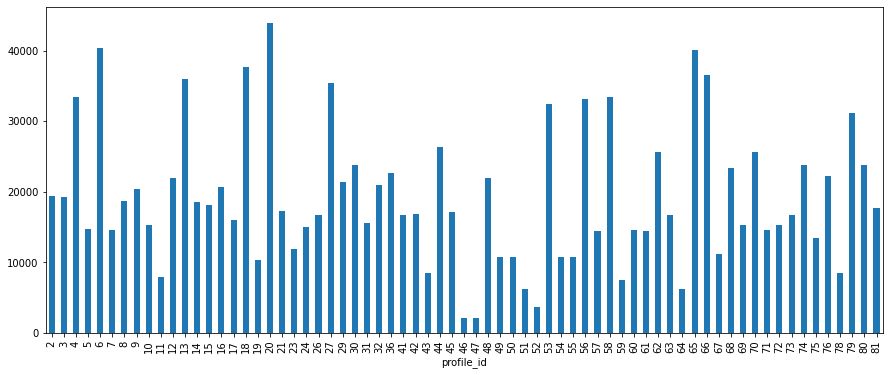

In [10]:
#tamanho de cada medição plotado para comparar
plt.figure(figsize=(15,6))
df.groupby('profile_id')['pm'].agg('count').plot(kind = 'bar')

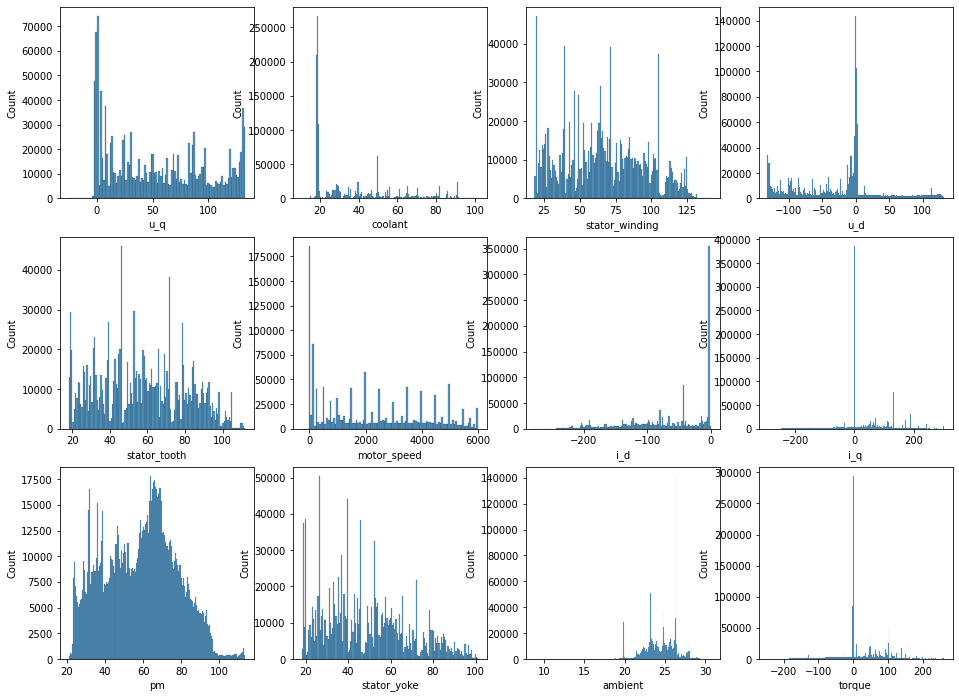

In [22]:
df_sem_id = df.drop(['profile_id'], axis=1) #tira a coluna id_profile
plt.figure(figsize=(16, 12))
for i in range(len(df_sem_id.columns)):
    plt.subplot(3, 4, i + 1)
    sns.histplot(data = df_sem_id[df_sem_id.columns[i]])
plt.show()

No handles with labels found to put in legend.


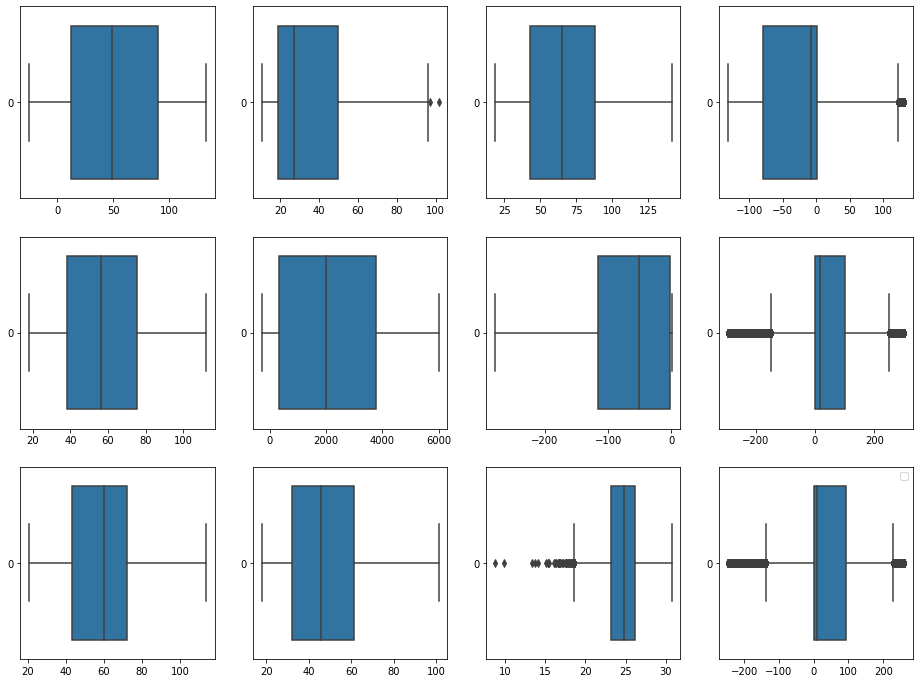

In [25]:
# boxplots e histogramas de todas as variáveis
plt.figure(figsize=(16, 12))
for i in range(len(df_sem_id.columns)):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data = df_sem_id[df_sem_id.columns[i]], orient = "h")
plt.show()


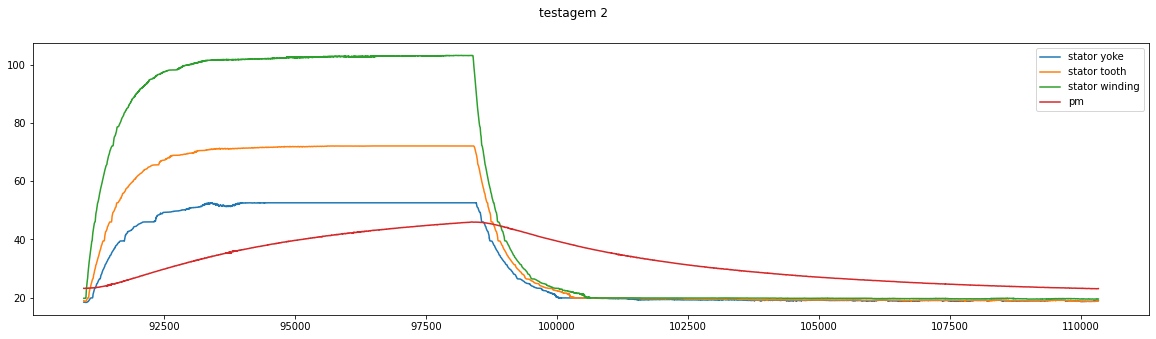

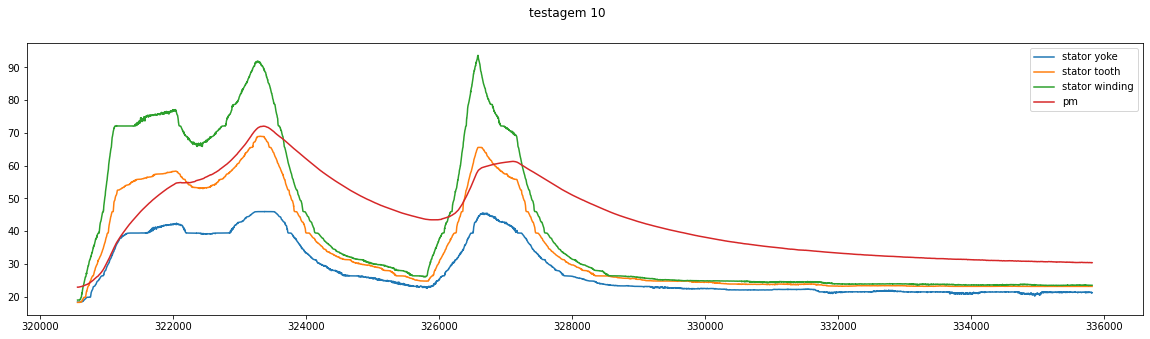

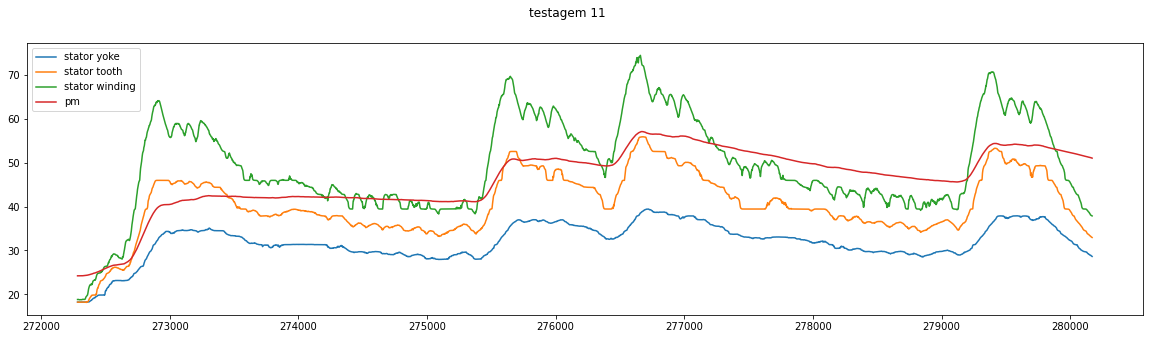

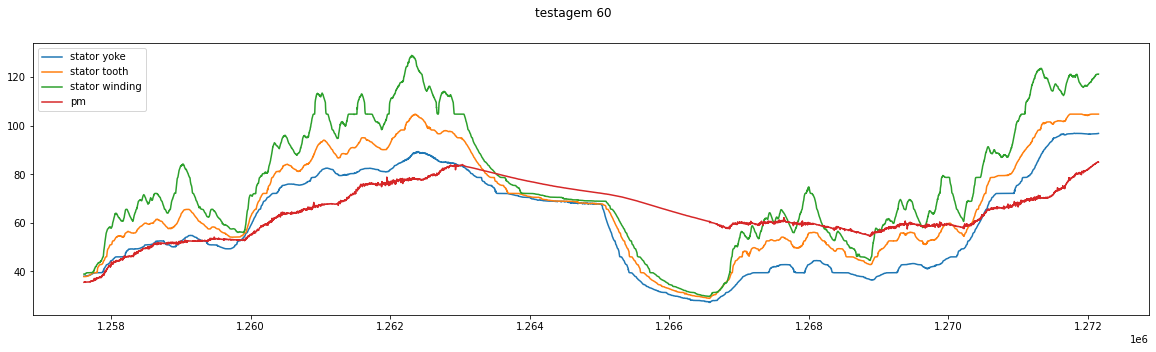

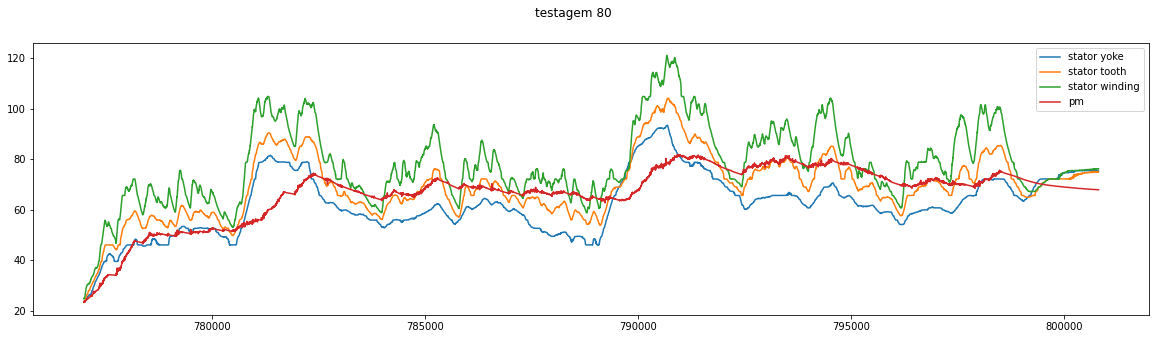

In [29]:
#plotagem dos valores das variáveis de saída de algumas realizações do teste
# como foram feitos 81 testagens, apenas uma amostra é apresentada visualmente

# visualmente se observa que a temperatura da parte magnética do estator (stator yoke), do dente do estator (stator tooth) e o enrolamento do estator (stator winding) se comportam de maneira proporcional, mas com intensidades diferentes
#já a variável da temperatura do rotor tem um comportamento diferente, com sua temperatura demorando mais a variar

testes_mostrados = [2, 10, 11, 60, 80]
for i in testes_mostrados:
    plt.figure(figsize=(20,5))
    df[df['profile_id'] == i]['stator_yoke'].plot(label = 'stator yoke')
    df[df['profile_id'] == i]['stator_tooth'].plot(label = 'stator tooth')
    df[df['profile_id'] == i]['stator_winding'].plot(label = 'stator winding')
    df[df['profile_id'] == i]['pm'].plot(label = 'pm')
    plt.suptitle(f'testagem {i}')    
    plt.legend()

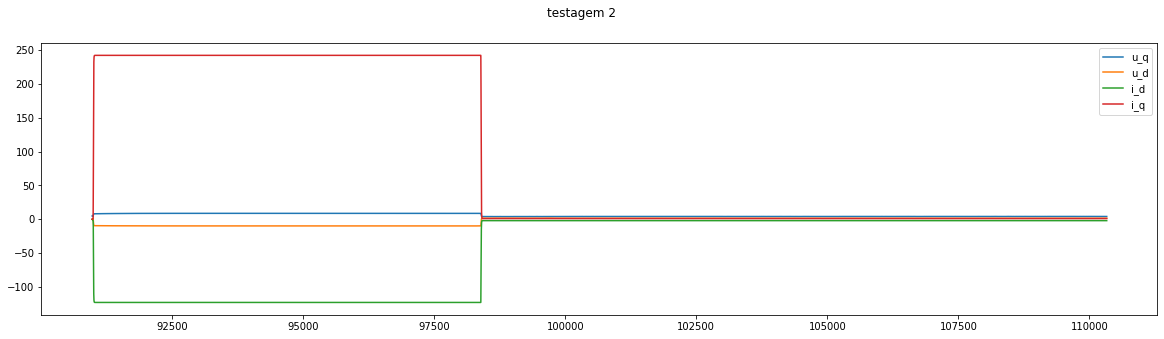

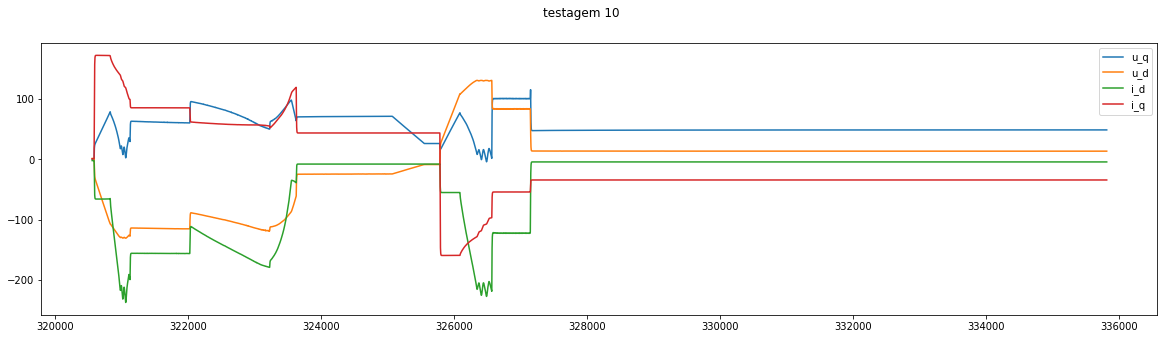

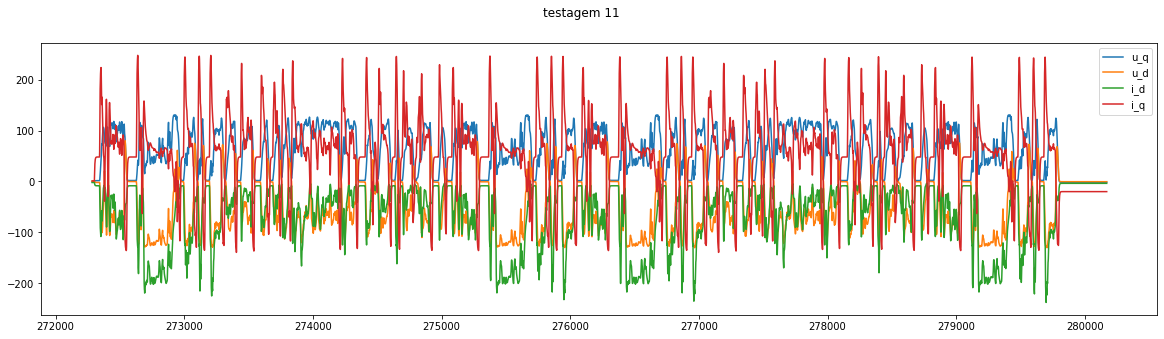

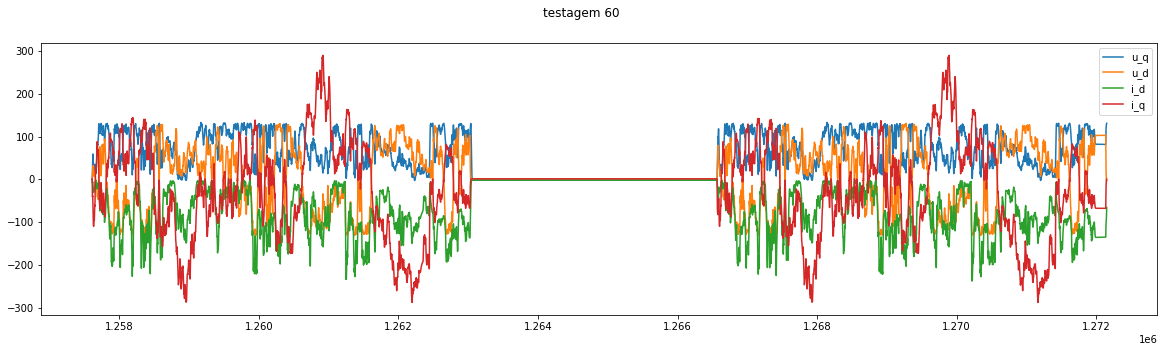

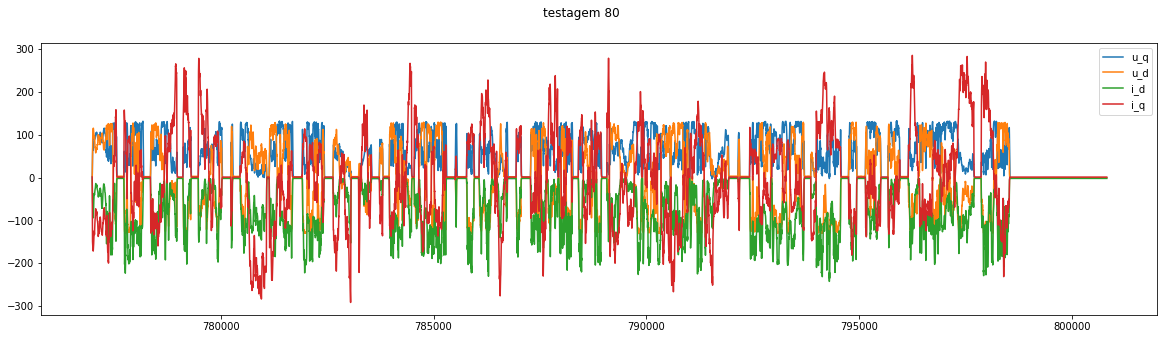

In [30]:
#plotagem dos valores das variáveis de entrada (voltagem, corrente) de algumas realizações do teste
for i in testes_mostrados:
    plt.figure(figsize=(20,5))
    df[df['profile_id'] == i]['u_q'].plot(label = 'u_q')

    df[df['profile_id'] == i]['u_d'].plot(label = 'u_d')
    df[df['profile_id'] == i]['i_d'].plot(label = 'i_d')
    df[df['profile_id'] == i]['i_q'].plot(label = 'i_q')


    plt.suptitle(f'testagem {i}')    
    plt.legend()

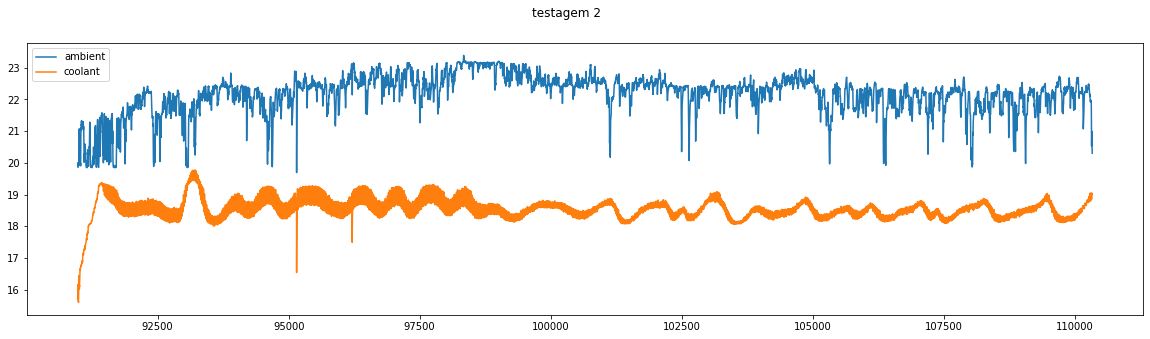

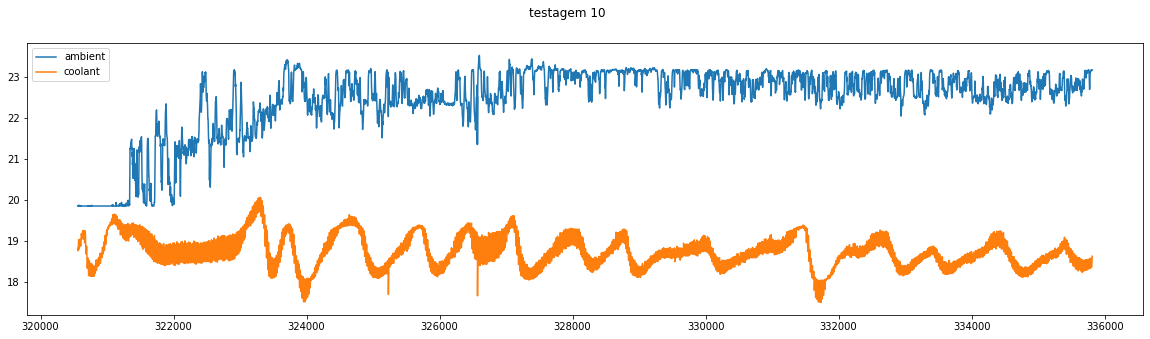

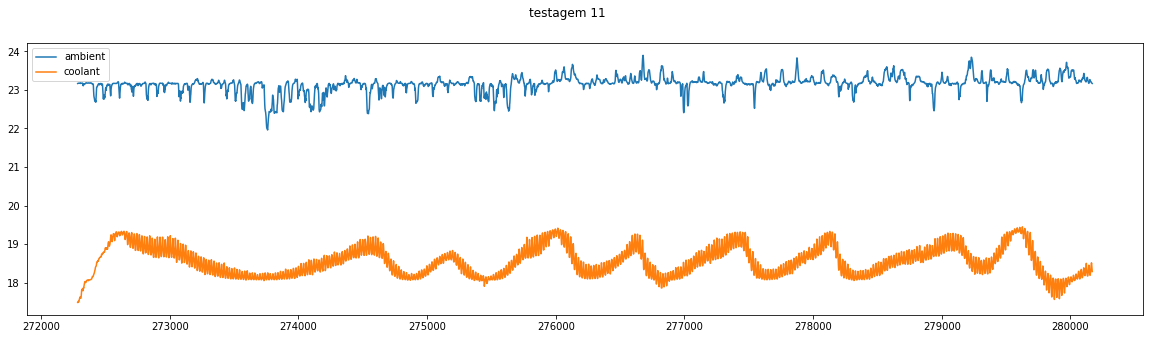

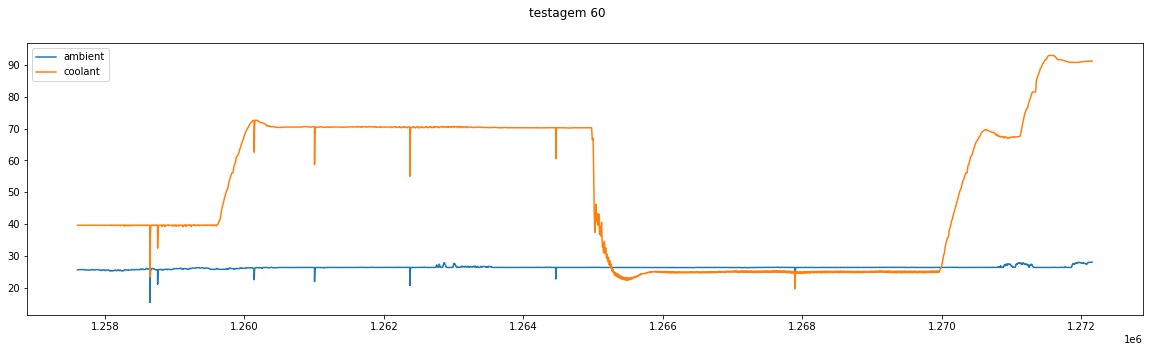

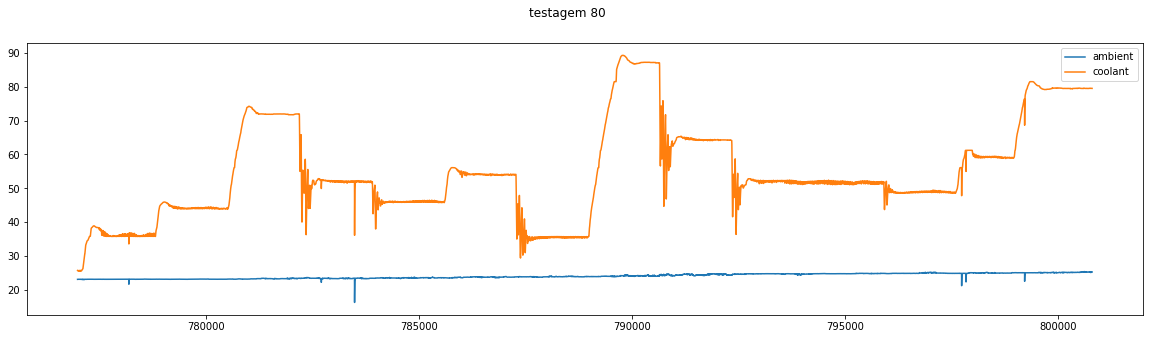

In [31]:
#variáveis de entrada da temperatura do liquido de arrefecimento e temperatura ambiente
for i in testes_mostrados:
    plt.figure(figsize=(20,5))
    df[df['profile_id'] == i]['ambient'].plot(label = 'ambient')
    df[df['profile_id'] == i]['coolant'].plot(label = 'coolant')
    plt.suptitle(f'testagem {i}')    
    plt.legend()

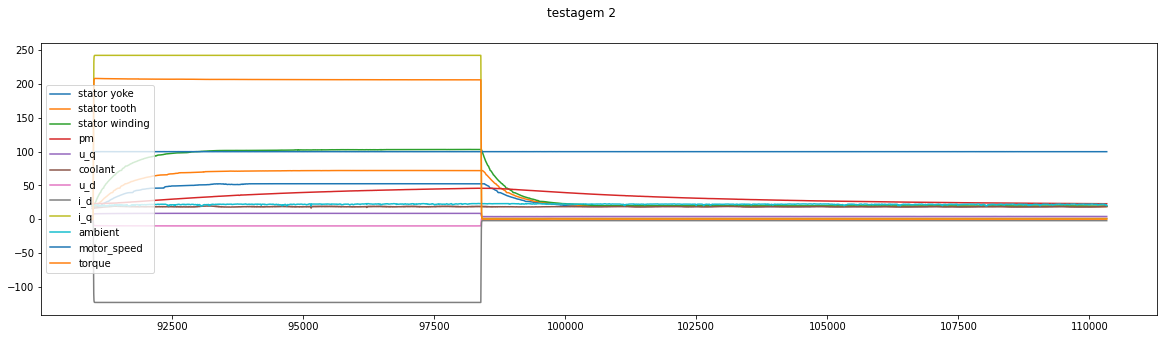

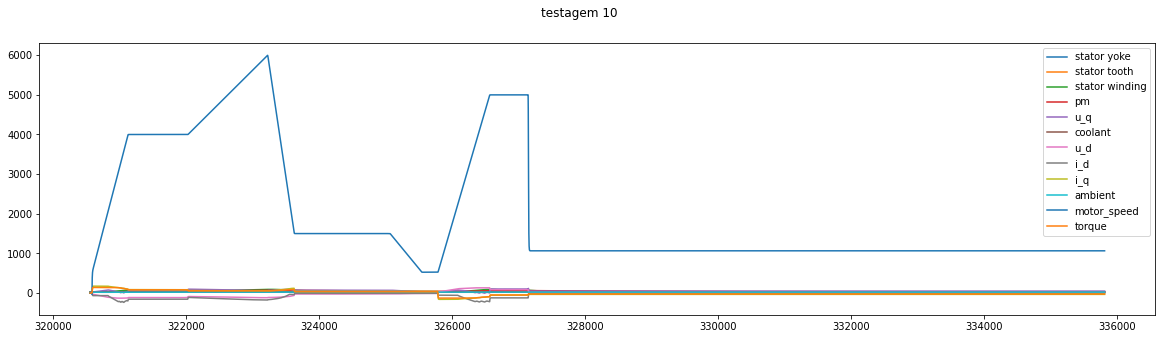

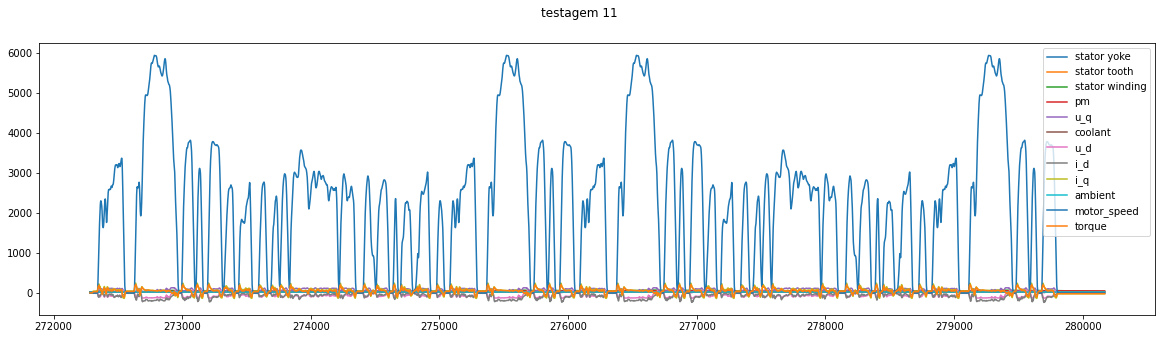

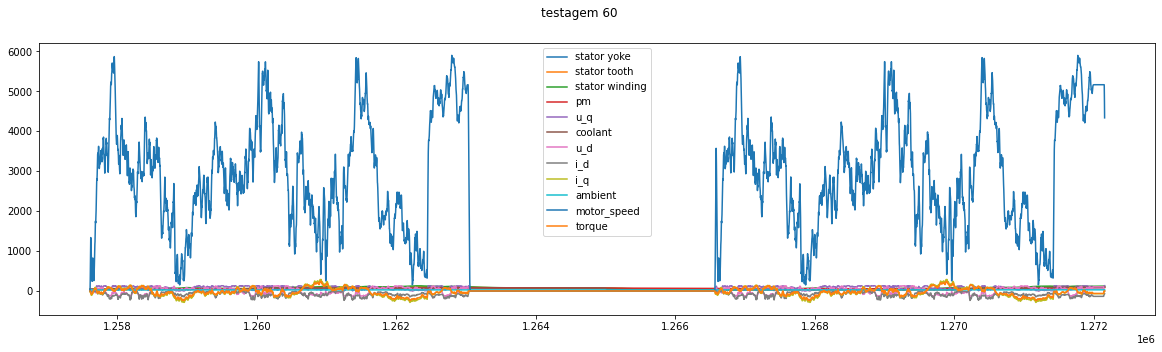

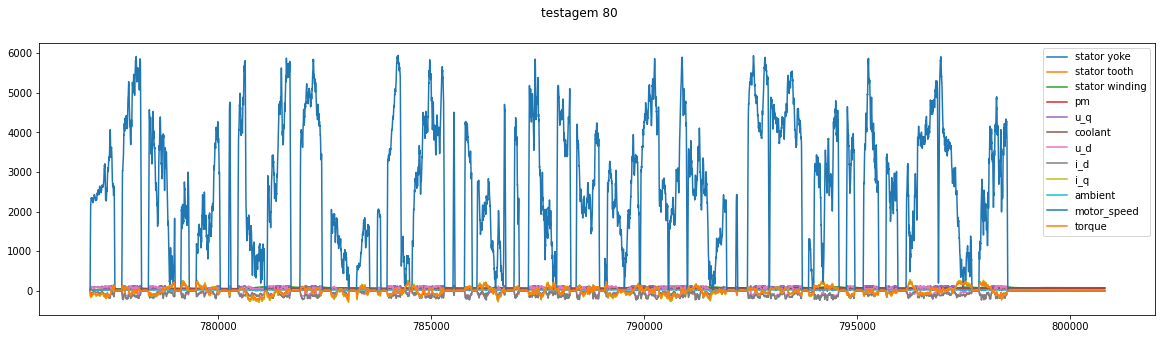

In [32]:
#variáveis de entrada e saídas juntas em algumas realizações do teste


# nos tres testes mostrados, é possível observar que assim que o motor é acionado e permanece constante, a temperatura começa a aumentar até alcançar uma certa estabilidade
#por outro lado, quando o motor é acionado e parado seguidas vezes, a temperatura alcança valores mais elevados
for i in testes_mostrados:
    plt.figure(figsize=(20,5))
    df[df['profile_id'] == i]['stator_yoke'].plot(label = 'stator yoke')
    df[df['profile_id'] == i]['stator_tooth'].plot(label = 'stator tooth')
    df[df['profile_id'] == i]['stator_winding'].plot(label = 'stator winding')
    df[df['profile_id'] == i]['pm'].plot(label = 'pm')
    df[df['profile_id'] == i]['u_q'].plot(label = 'u_q')
    df[df['profile_id'] == i]['coolant'].plot(label = 'coolant')
    df[df['profile_id'] == i]['u_d'].plot(label = 'u_d')
    df[df['profile_id'] == i]['i_d'].plot(label = 'i_d')
    df[df['profile_id'] == i]['i_q'].plot(label = 'i_q')
    df[df['profile_id'] == i]['ambient'].plot(label = 'ambient')
    df[df['profile_id'] == i]['motor_speed'].plot(label = 'motor_speed')
    df[df['profile_id'] == i]['torque'].plot(label = 'torque')
    plt.suptitle(f'testagem {i}')    
    plt.legend()

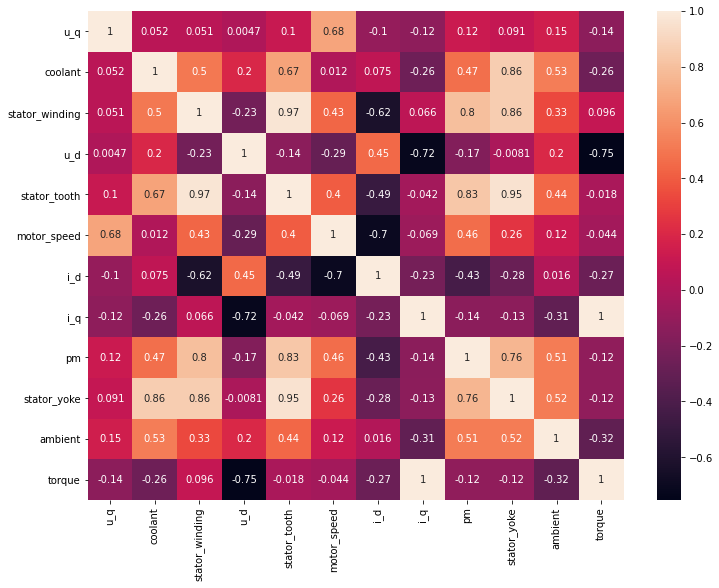

In [33]:
# matriz de correlações de pearson
fig = plt.figure(figsize=(12,9))
sns.heatmap(df_sem_id.corr(),annot=True)
plt.show()

<Figure size 360x360 with 0 Axes>

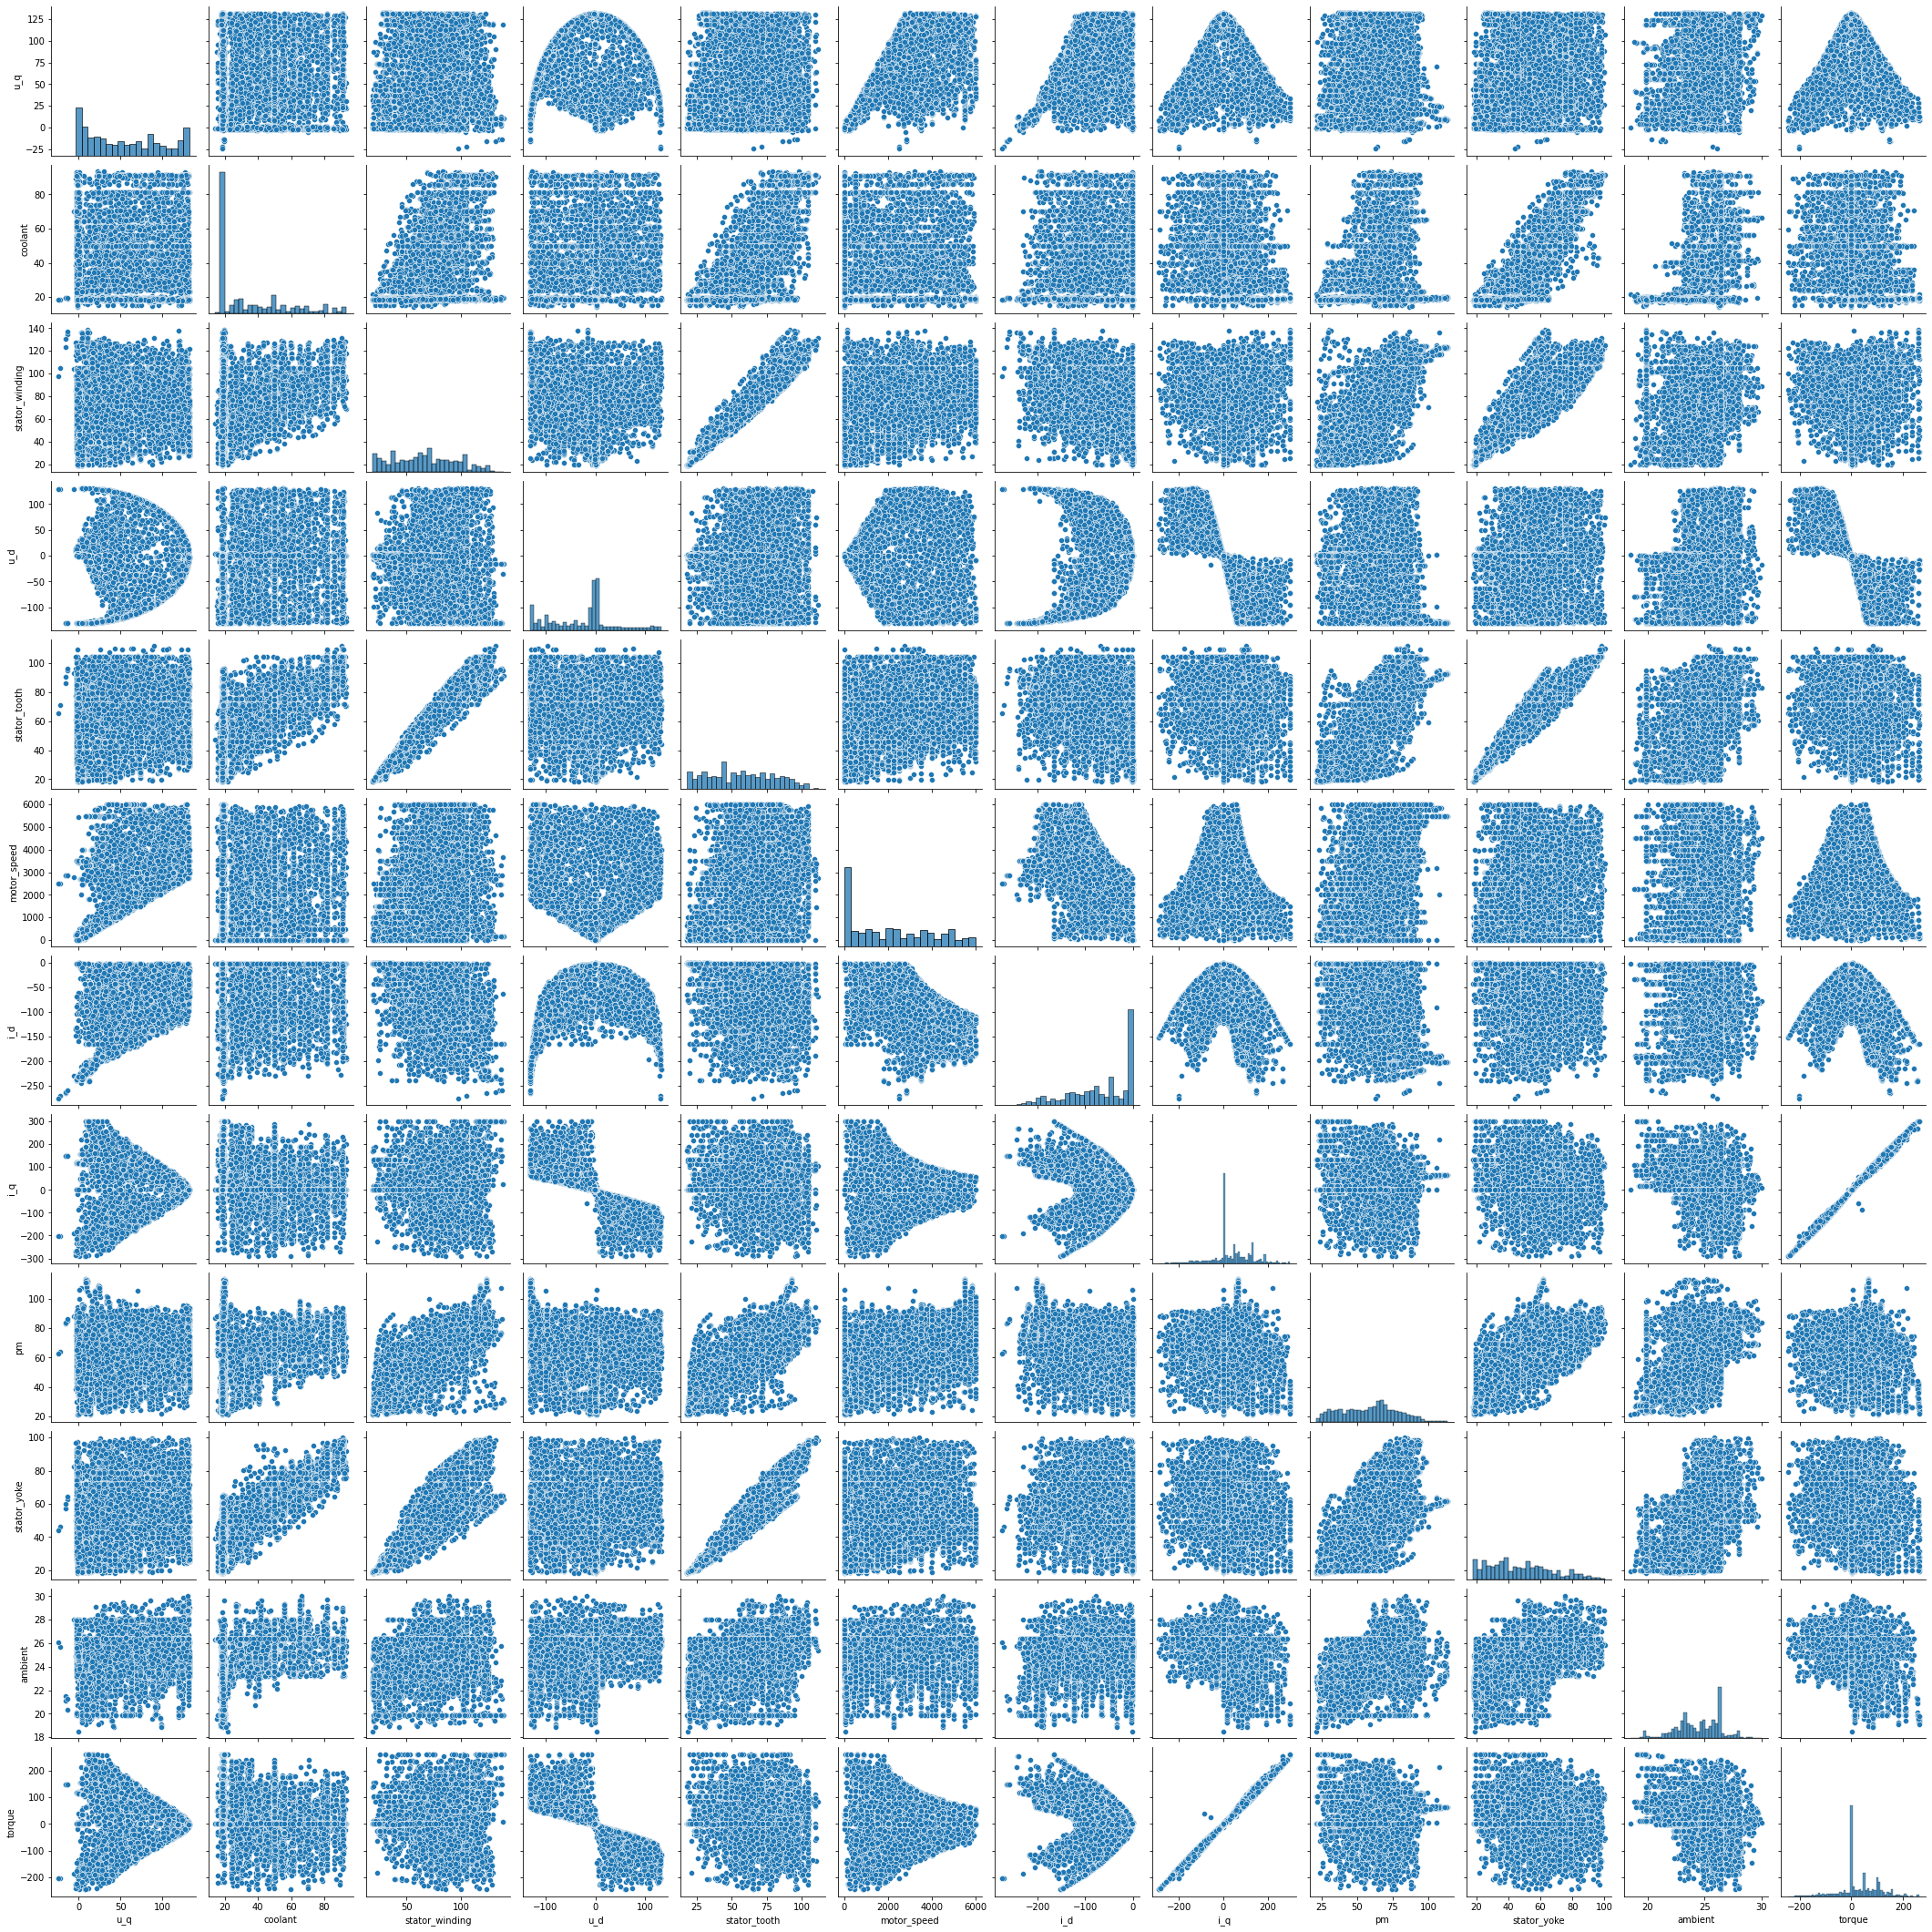

In [35]:
#plotagem de todas as dispersões entre as variáveis
#sorteando apenas 10000 valores 
plt.figure(figsize=(5, 5))
sns.pairplot(df_sem_id.sample(10000))
plt.show()